$$\require{mhchem}$$
# Overlaying optical and mass spectrometry imaging datasets using OpenMSI and IPython

This notebook shows an example of comparing optical and mass spectrometry images in IPython using OpenMSI components to read the MSI data files.

The data here is very simple: it is a manually spotted 384-well MALDI plate containing spots with **canola oil** (top row), or  **toasted sesame oil** (middle row) or sample blanks (i.e. MALDI matrix with no sample; bottom row).  Each sample was replicated six times within each row.

Samples were prepared by pre-spotting MALDI matrix (an equimolar mixture of <a href="http://en.wikipedia.org/wiki/Gentisic_acid">DHBA</a> and <a href="http://en.wikipedia.org/wiki/Alpha-Cyano-4-hydroxycinnamic_acid">&alpha;-cyano-4-hydroxycinnamic acid (CHCA)</a>) in a stainless steel MALDI plate.  After the spots dried, 1 &mu;L aliquots of the oil samples, each diluted 1000x in chloroform containing 0.1% trifluoroacetic acid, were manually pipetted on top of the MALDI spots.

MALDI acquisition was with a Thermo LTQ-XL Orbitrap mass spectrometer operating in the Orbitrap mode.  

MS<sup>2</sup> data was obtained for two ions: from a (triolein+Na<sup>+</sup>) ion at 907.73 Da ($\cf{C57H104O6Na+}$), and from a related ion at 906.76 Da, which arises primarily from <sup>13</sup>C substitution on a singly-unsaturated variant of triolein, $\cf{^{12}C56~^{13}C1H102O6Na+}$).  The observed ions in each MS<sup>2</sup> spectrum are primarily from loss of a single acyl chain.

In canola oil, triolein is the most abundant triacylglycerol.  In contrast, in toasted sesame oil triolein is present but in a relatively lower amount (lower-molecular weight TAGs are more abundant).

Although the samples were spotted on a 384-well plate, data were acquired in imaging mode (~400 &mu;m spatial resolution) to serve as an example of OpenMSI and IPython processing of mass spectrometry imaging and optical data.  Spatial resolution was kept low to keep the file size small for this example analysis.

## Preliminaries: importing required Python modules, providing paths to data

In [1]:
### Importing required python modules for these computations ####
# General stuff:
%matplotlib inline
import numpy as np
import mkl
import matplotlib.pyplot as plt
from scipy import misc
import matplotlib.cm as cm

import sys
def isneeded(x):
    if x not in sys.path:
        sys.path.append(x)

isneeded('/Users/curt/openMSI_SVN/openmsi-tk/')
isneeded('/Users/curt/openMSI_localdata/')

#OpenMSI stuff for getting my source images:
from omsi.dataformat.mzml_file_CF import *

# Image registration
import imreg_dft as ird

## Reading MSI data into IPython using OpenMSI's `mzml_file()` reader.

In [2]:
#Reading a datafile of spotted samples in MALDI
omsi_ms2 = mzml_file(basename="/Users/curt/openMSI_localdata/re-reimaging_TI.mzML")

Read 2806 scans from mzML file.
Found 3 different scan types in mzML file.
Processed data for 0 spectra to datacube for scan type ITMS + p MALDI Z ms2 907.73@cid60.00 [500.00-700.00]
Processed data for 1000 spectra to datacube for scan type ITMS + p MALDI Z ms2 907.73@cid60.00 [500.00-700.00]
Processed data for 2000 spectra to datacube for scan type ITMS + p MALDI Z ms2 907.73@cid60.00 [500.00-700.00]
Processed data for 0 spectra to datacube for scan type FTMS + p MALDI Full ms [850.00-1000.00]
Processed data for 1000 spectra to datacube for scan type FTMS + p MALDI Full ms [850.00-1000.00]
Processed data for 2000 spectra to datacube for scan type FTMS + p MALDI Full ms [850.00-1000.00]
Processed data for 0 spectra to datacube for scan type ITMS + p MALDI Z ms2 906.76@cid60.00 [500.00-700.00]
Processed data for 1000 spectra to datacube for scan type ITMS + p MALDI Z ms2 906.76@cid60.00 [500.00-700.00]
Processed data for 2000 spectra to datacube for scan type ITMS + p MALDI Z ms2 906.76

##### Plotting the TIC images and example spectra from the MSI data

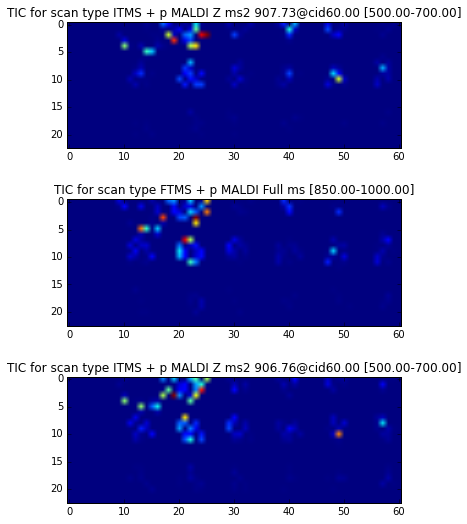

In [3]:
#Plotting TIC images for each scan type
f, axarr = plt.subplots(3, 1, figsize=(6, 9))
for ind in range(len(omsi_ms2.data)):
    axarr[ind].imshow(omsi_ms2.data[ind][:, :, :].sum(axis=2).T)  #total ion chromatogram images
    axarr[ind].set_title('TIC for scan type '+omsi_ms2.scan_types[ind])

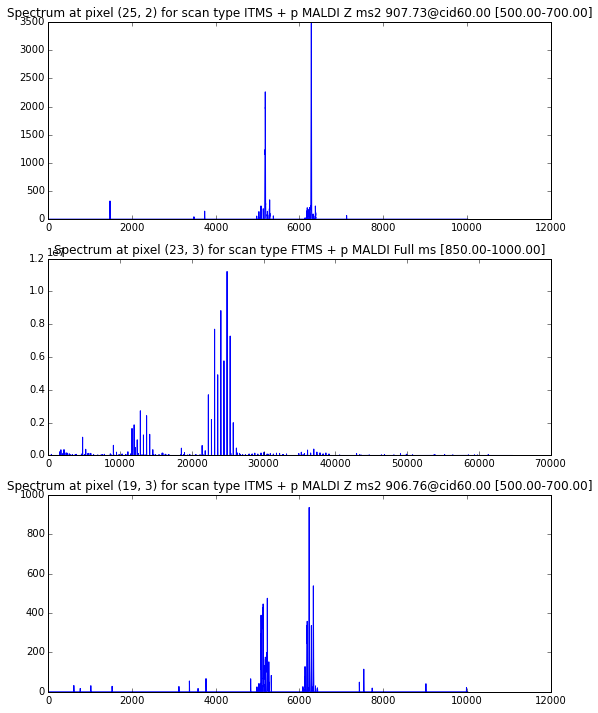

In [4]:
#Plotting spectra at the most intense pixel for each scan type:
f, axarr = plt.subplots(3, 1, figsize=(9, 12))
for ind in range(len(omsi_ms2.data)):
    nx, ny, nmz = omsi_ms2.data[ind].shape
    maxx, maxy = np.unravel_index(omsi_ms2.data[ind][:, :, :].sum(axis=2).argmax(), dims=[nx, ny])
    axarr[ind].plot(omsi_ms2.data[ind][maxx, maxy, :])  
    axarr[ind].set_title(('Spectrum at pixel (%s, %s) for scan type ' % (maxx, maxy))+omsi_ms2.scan_types[ind])

## Importing an optical image into Python

In this example, we align an optical image with the MSI image.  Although this data is for a region of a spotted MALDI plate, in the future the same code could be applied to tissue images, such as histochemical iamges.

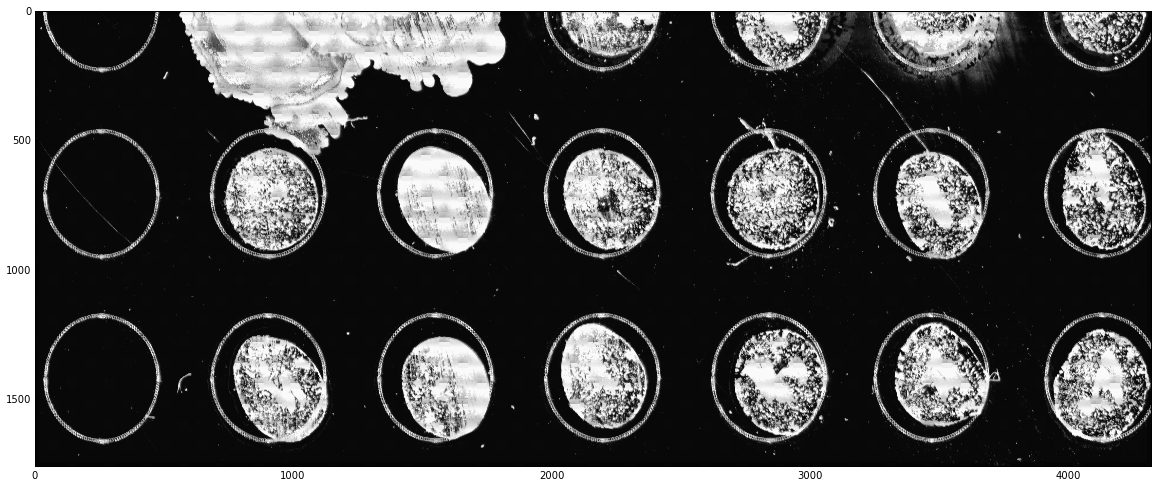

In [5]:
#grayscale image of plate:
photo = misc.imread('/Users/curt/openMSI_localdata/Simple_canolaTAG_vs_sesameTAG_vs_blank_plate_image.bmp')
plt.figure(figsize=(20,10))
f = plt.imshow(photo, cmap=cm.Greys_r)

## Registration (i.e. matching & lining up) the optical image with the MSI image.
##### Prepration for registration: resizing images and normalizing MS image by chosen representative ion

In this "big crystal" MALDI experiment, the presence of "hot spots" means that intensity of a given ion varies wildly from pixel to pixel.  Normalizing the MS image by a particular ion helps eliminate this effect and shows more clearly the spot locations in the MSI data.  For tissue images where MALDI "hot spots" are not an issue, this step would probably not be required.

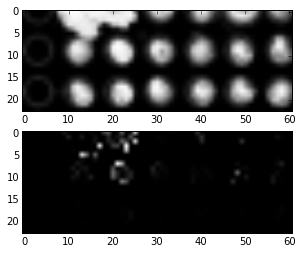

In [6]:
#plotting optical image resized to be the same size as MS image

ms1ticImage = omsi_ms2.data[1][:, :, :].sum(axis=2).T
photoSmall = misc.imresize(photo,ms1ticImage.shape)

f, ax = plt.subplots(2, 1)
ax[0].imshow(photoSmall, cmap=cm.Greys_r)
ax[1].imshow(ms1ticImage, cmap=cm.Greys_r)

float64


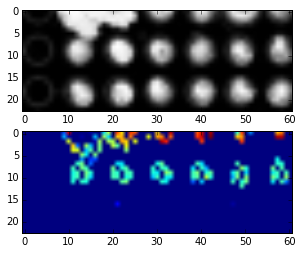

In [7]:
#Normalize the MS image by the intensity of the triolein MS1 peak
mzind = abs(omsi_ms2.mz[1]-907.7738).argmin()
ms1_907 = omsi_ms2.data[1][:, :, mzind-2:mzind+2].sum(axis=2).T
normimage = ((ms1_907)) / (ms1ticImage+1.)
print normimage.dtype
f, ax = plt.subplots(2, 1)
ax[0].imshow(photoSmall, cmap=cm.Greys_r)
ax[1].imshow(normimage)

##### Doing image registration: finding the optimal overlay of the images, and plotting the result

[0 0]


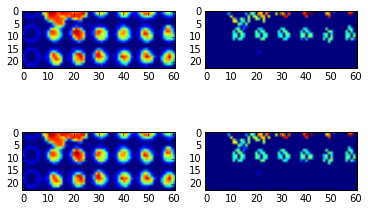

In [8]:
result = ird.similarity(photoSmall, normimage, numiter=20)
f, axarr = plt.subplots(2,2)
axarr[0, 0].imshow(photoSmall)
axarr[0, 1].imshow(normimage)
axarr[1, 0].imshow(photoSmall-normimage)
axarr[1, 1].imshow(result['timg'])
print result['tvec']

## Final result: 
## an overlay of interpolated MS<sup>1</sup> intensity for the triolein ion on the optical image

In [9]:
#Overlaying the "registered" MSI data on the optical image to make the final plot
msBig = misc.imresize(result['timg'], photo.shape, 'bicubic')

msBig_masked = np.ma.masked_where(msBig <= 35, msBig)

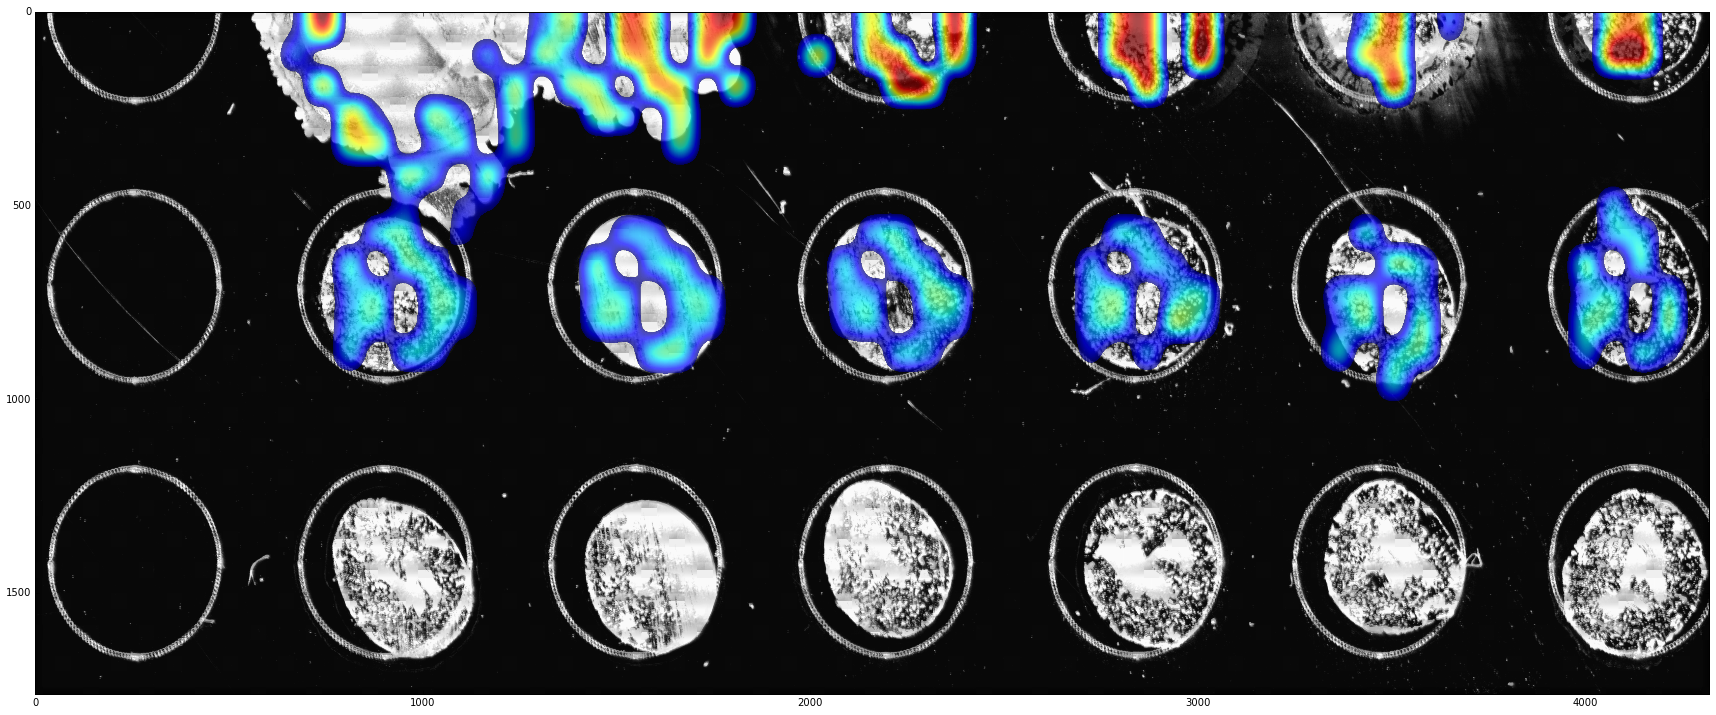

In [10]:
plt.figure(figsize=(30,15))
plt.imshow(photo, cmap=cm.Greys_r, alpha=1)
plt.imshow(msBig_masked, alpha=0.7)